In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

Answer :
<blockquote> The SVM problem in the primal space, following:

$$\underset{w, b,\xi}{\mathrm{min}} \quad \frac{1}{2}||w||^2+ C \sum_{i=1}^{n} \xi _i$$

Such that:

$$y_i(w^Tx_i+b)\ge 1 - \xi_i \quad i=1,...,n\\
\xi_i \ge 0 \quad i=1,...,n$$

For the kernel SVM, the data is transformed according a nonlinear feature map $\phi$ : $\mathbb{X} \rightarrow \mathbb{F}$. Then, the SVM is applied in this new feature space. <br>

Thus, the equation above can be rewritten to contemplate this transformation:

$$\underset{w, b,\xi}{\mathrm{min}} \quad \frac{1}{2}||w||^2+ C \sum_{i=1}^{n} \xi _i\\
y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+b)\ge 1 - \xi_i \quad i=1,...,n\\
\xi_i \ge 0 \quad i=1,...,n$$

The constraints can be written as: 

$$\xi_i = max(0,1-y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+b))$$

That is the same as:
$$\xi_i = [1-y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+b)]_+$$

Therefore, if $\xi_i$ is substituted in the first equation, the primal problem can be written as described if $b \equiv w_0$:

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.


The statement refers to the property of SVM optimization that it minimizes a convex upper bound on the classification error instead of directly minimizing the error itself.       

The hinge loss function is a convex function. By using this as the loss function in SVM, the optimization problem becomes convex, ensuring that it has a unique global minimum. Convexity is desirable in optimization because it guarantees convergence to the global optimum.

The difference between the pivotal loss and the loss of binary classification lies in their functions and purposes:

- Pivotal Loss (Hinge Loss): This is the loss function used in SVM. It is defined as $\text{max}(0, 1 - y_i (\langle \mathbf{w}, \Phi(\mathbf{x}_i) \rangle + w_0))$. It penalizes misclassifications by increasing linearly as the distance between the correct class boundary and the predicted class boundary increases. It aims to maximize the margin between classes while allowing for some misclassification.

- Loss of Binary Classification: This refers to the overall loss incurred by a binary classification model. It could be any loss function used to measure the discrepancy between the predicted labels and the true labels, such as the zero-one loss function (which assigns a loss of 0 for correct predictions and a loss of 1 for incorrect predictions), cross-entropy loss, etc. Unlike the hinge loss, the loss of binary classification does not necessarily have to be convex, and its form depends on the specific problem and chosen loss function.
            

## Example of using the SVC class from scikit-learn

In [37]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d) #each line of res represents a point
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.95
Testing score : 0.95


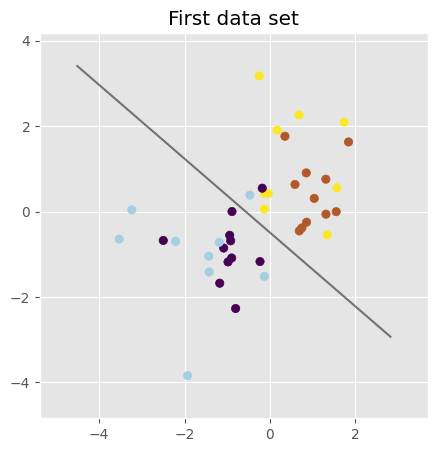

In [38]:
# This is an example of using SVC for data generated with the above function
n1 = 20  # number of points in class 1
n2 = 20  # number of points in class 2
mu1 = [1., 1.]  # mean of class 1
mu2 = [-1., -1.] # mean of class 2
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')  #initialize the classifier with a linear kernel
clf.fit(X_train, Y_train) #fit the classifier with the training data

# predict labels for the test data base
y_pred = clf.predict(X_test) #predict the labels of the test data

# check your score
score_train = clf.score(X_train, Y_train) 
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.


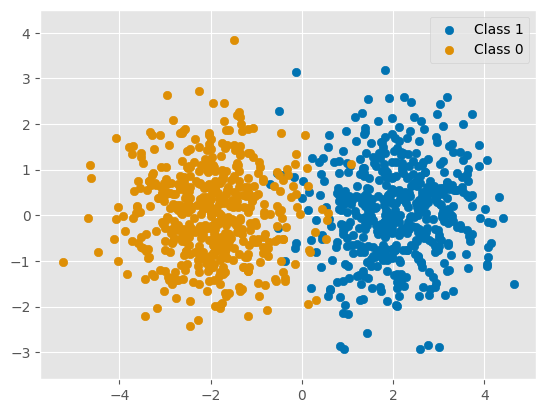

In [39]:
# Create two centers for the two distributions 
centers = [[-2, 0], [2, 0]]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=1000, centers=centers, random_state=42)

# Plot the points with colorblind-friendly palette
sns.set_palette("colorblind")
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], color=sns.color_palette()[0], label='Class 1')
plt.scatter(X[neg,0], X[neg,1], color=sns.color_palette()[1], label='Class 0')
plt.axis('equal')
plt.legend()
plt.show()


In [40]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**4)** Since the probability distributions are known, numerically estimate the Bayes risk. 


In [41]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use 
# to approximate the integral of the Bayes risk
n_mc = 10000 # Repeat this n_mc times - enough to approximate 
expectation = 0
covariance = np.eye(2)

for i in range(n_mc):
    rand = np.random.randint(0, 2) # Random binary choice: will the point be generated from the first or second gaussian ? 
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal([-2, 0], covariance)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal([2, 0], covariance)

    # You have to compute the conditional posterior probability of x given the 2 gaussians 
    # Use the multivariate_normal.pdf() method !    
    p1 = multivariate_normal.pdf(x, mean=[-2, 0], cov=covariance)
    p2 = multivariate_normal.pdf(x, mean=[2, 0], cov=covariance)
    
    # Compute the risk from these and add it to the total
    loss = min(p1, p2) 
    expectation += loss

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.001
Estimated Bayes accuracy: 0.999


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.


<blockquote> As can be seen in the graphs bellow, increasing the value of the parameter C is equivalent to make the margin narrower.<br>
    
For the SVM in a nonlinear separable case, the C parameter is introduced as a penalization for misclassifying a point. The problem can be written as follows:
    
$$\underset{w, b,\xi}{\mathrm{min}} \quad \frac{1}{2}||w||^2+ C \sum_{i=1}^{n} \xi _i$$

Such that:

$$y_i(w^Tx_i+b)\ge 1 - \xi_i \quad i=1,...,n\\
\xi_i \ge 0 \quad i=1,...,n$$

Therefore, the C constant is the tradeoff between minimizing the models complexity (maximizing the margins) and allowing misclassifications.

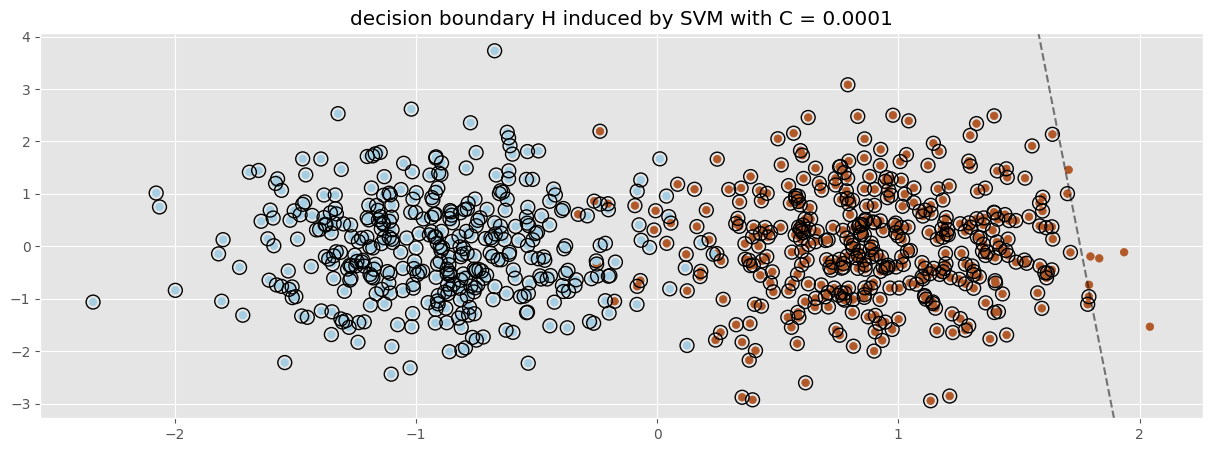

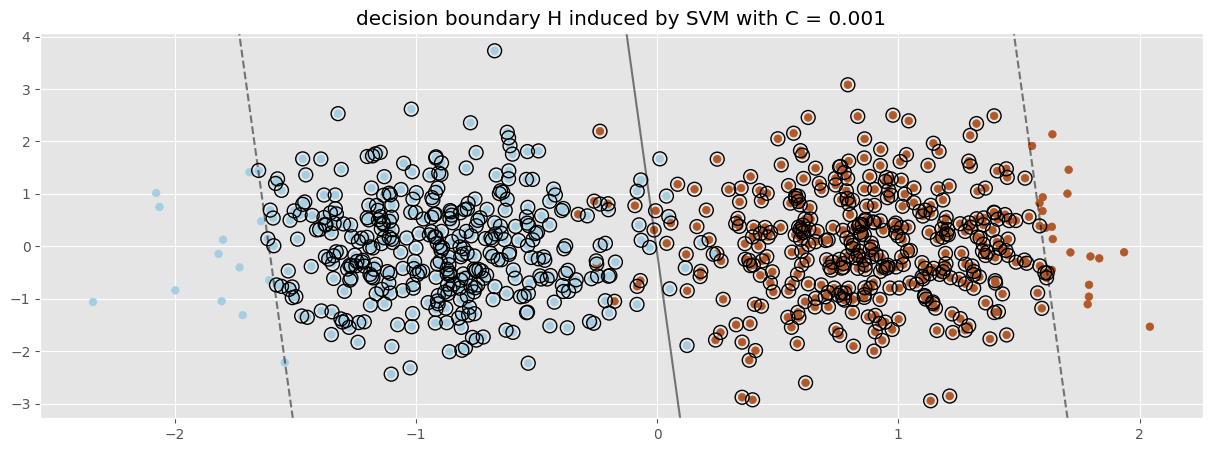

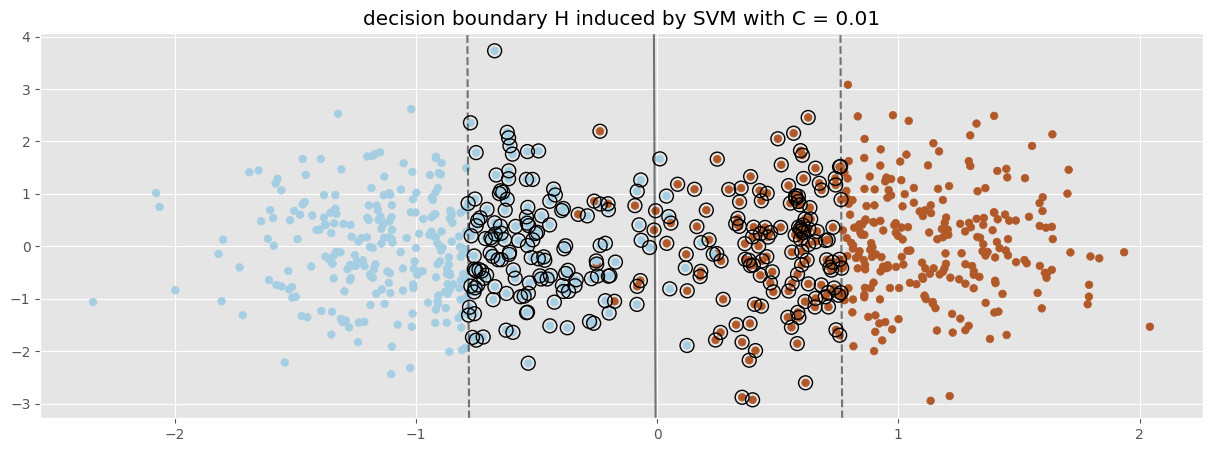

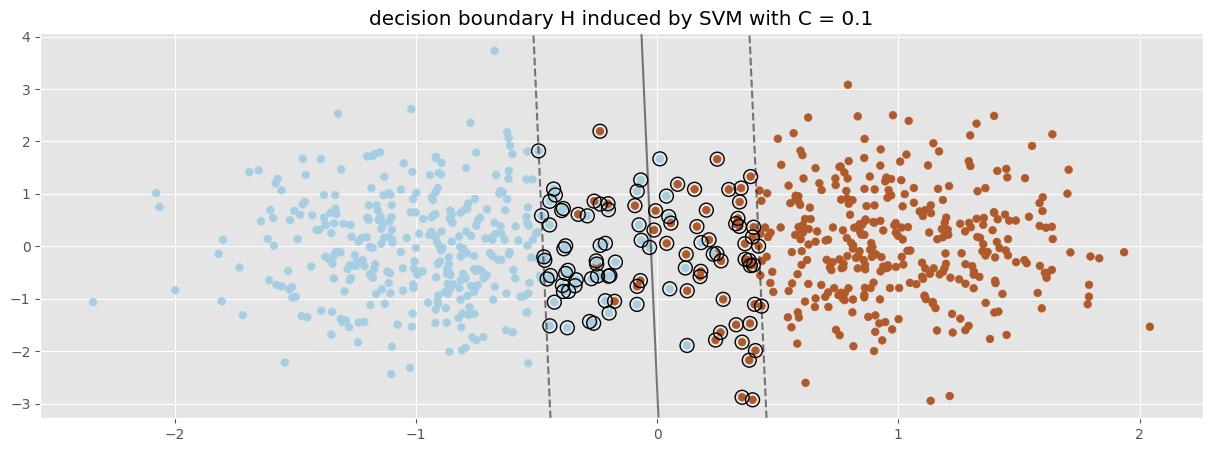

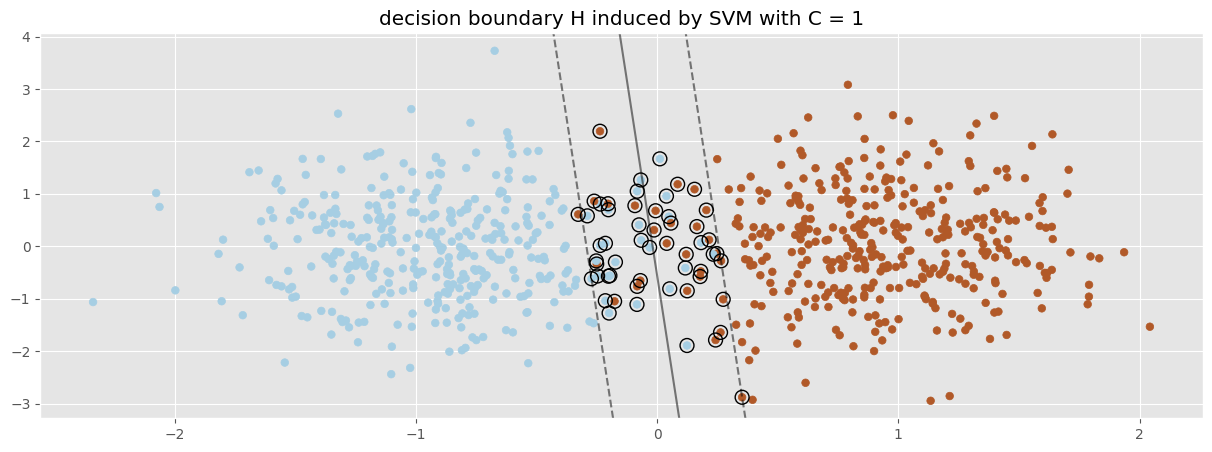

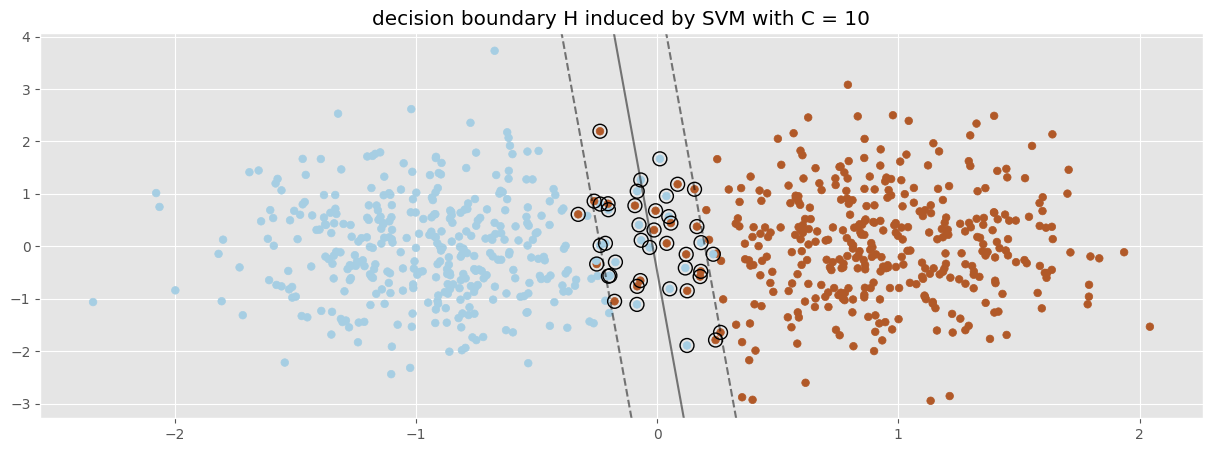

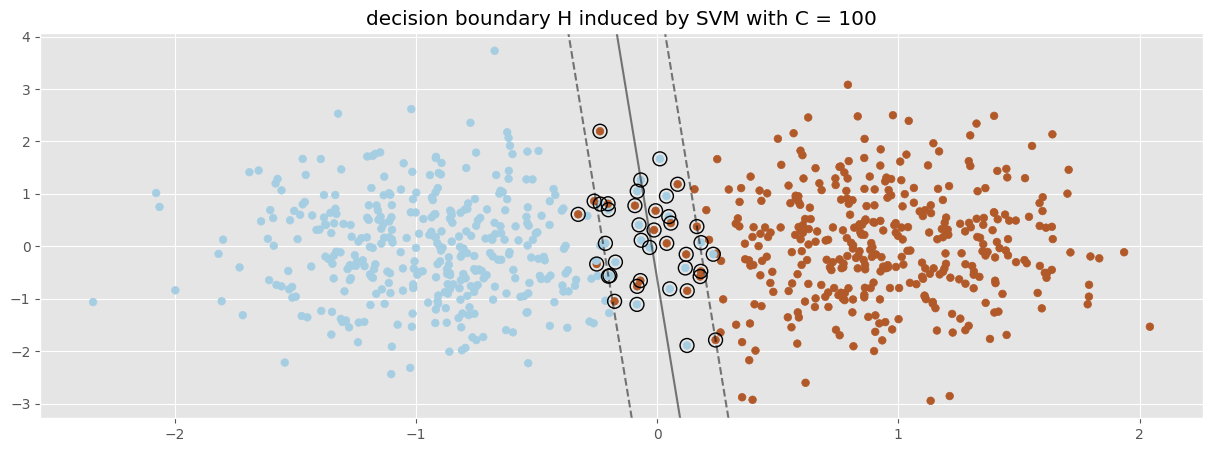

In [42]:
plt.close('all')
for i in [0.0001,0.001, 0.01, 0.1,1,10,100]:
    
    lsvm = SVC(C=i,kernel='linear')
    lsvm.fit(X_train,y_train)
    
    plt.figure(figsize=(15,5))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = lsvm.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(lsvm.support_vectors_[:, 0], lsvm.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.title("decision boundary H induced by SVM with C = "+str(i))
    plt.show()

The number of support vectors decrease with the increase of $C$.

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.


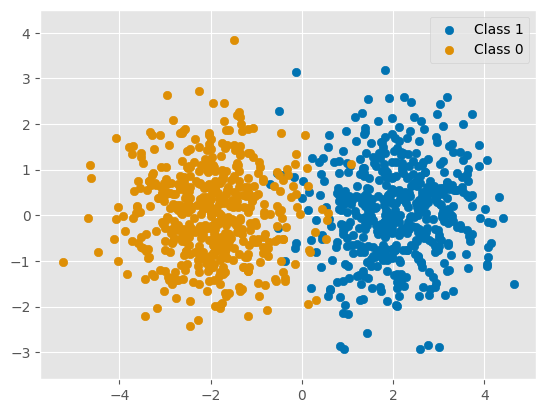

In [43]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3

# Create two centers for the two distributions with overlapping Gaussian classes
centers = [[-2, 0], [2, 0]]  

# Use make_blobs to generate the two-dimensional points from the two centers
X, y = make_blobs(n_samples=1000, centers=centers, random_state=42)

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Plot the points with colorblind-friendly palette
sns.set_palette("colorblind")
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos, 0], X[pos, 1], color=sns.color_palette()[0], label='Class 1')
plt.scatter(X[neg, 0], X[neg, 1], color=sns.color_palette()[1], label='Class 0')
plt.axis('equal')
plt.legend()
plt.show()



Best training Score: 0.97625
Best training params: {'C': 0.0034891012134067737}


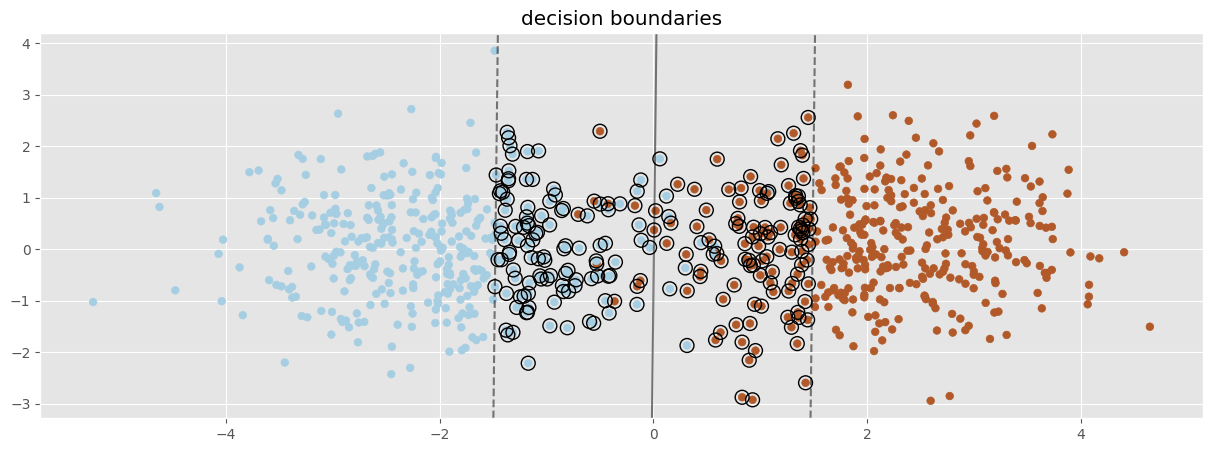

In [44]:
# Find the best working C with a 5-fold cross-validation
plt.close('all')
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': list(np.logspace(-3, 3, 200))}
lsvm = SVC(kernel='linear')
grid_lsvm = GridSearchCV(lsvm, p_grid_lsvm, cv=5)
grid_lsvm.fit(X_train, y_train)
best_par=grid_lsvm.best_params_
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))

lsvm = SVC(C=best_par['C'],kernel='linear')
lsvm.fit(X_train,y_train)

plt.figure(figsize=(15,5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = lsvm.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(lsvm.support_vectors_[:, 0], lsvm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

ax.set_title("decision boundaries")
plt.show()


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.


<blockquote> The problem of overfitting happens when an over complex model is used, therefore, the model starts to fit the noise in the training data set. When that happens, it loses its power of generalization, resulting in poor results on the test set.<br><br>
    
Below, multiple tests were done, each time with a different combination of C and Gamma parameters. The graph shows the test and train score for each test. It can be seen that the cases where the train score was best, in fact had poor test score, that is, were indeed cases of overfitting.


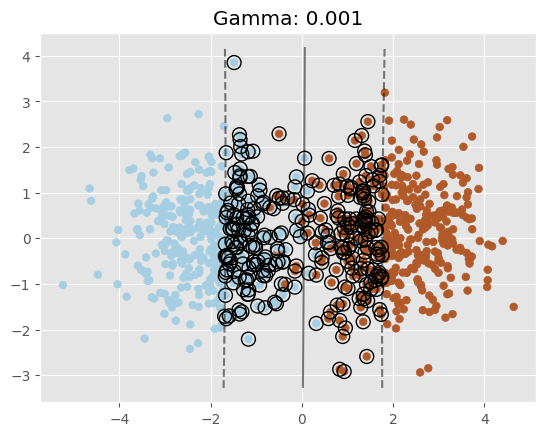

Train/Test scores: 0.97375/0.98 --- Gamma: 0.001


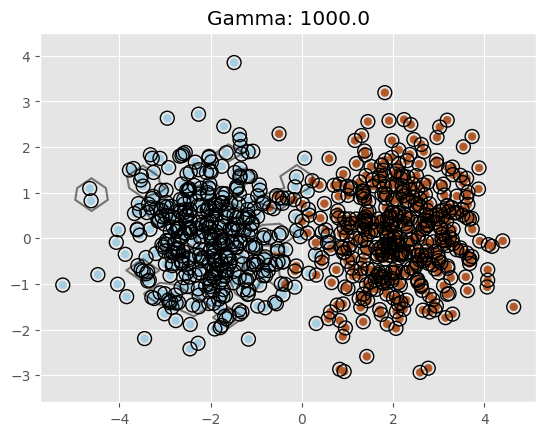

Train/Test scores: 1.0/0.6 --- Gamma: 1000.0


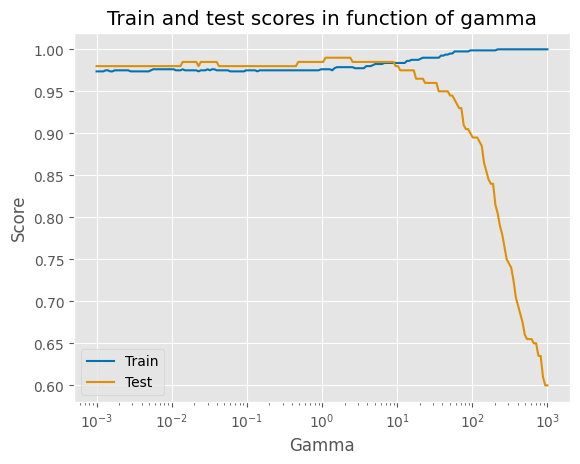

In [45]:
gammas = np.logspace(-3, 3, 200)
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
#To create a gaussian svm we need to use rgd argument
model = svm.SVC(kernel='rbf')

scores = []

#On parcourt gammas
for gamma in gammas:
    model.gamma = gamma
    model.fit(X_train, y_train)
    #print(f'Train/Test scores: {svm.score(X_train, y_train)}/{svm.score(X_test, y_test)} --- Gamma: {gamma}')

    scores.append((model.score(X_train, y_train), model.score(X_test, y_test)))

    if gamma in [0.001, 100, 1000]:
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = model.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                    linestyles=['--', '-', '--'])
        # plot support vectors
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                        linewidth=1, facecolors='none', edgecolors='k')
        

        plt.axis('equal')
        plt.title(f'Gamma: {gamma}')
        plt.show()

        print(f'Train/Test scores: {model.score(X_train, y_train)}/{model.score(X_test, y_test)} --- Gamma: {gamma}')

#display scores
plt.plot(gammas, [s[0] for s in scores], label='Train')
plt.plot(gammas, [s[1] for s in scores], label='Test')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Score')
plt.title('Train and test scores in function of gamma')
plt.legend()
plt.show()

We can see that the higher gamma is, the more the model will tend to overfit.

With $\gamma=100$, the model create areas around the training data only. Leading to a very high train score (the model overfit on training fata) but a very poor testing score.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).


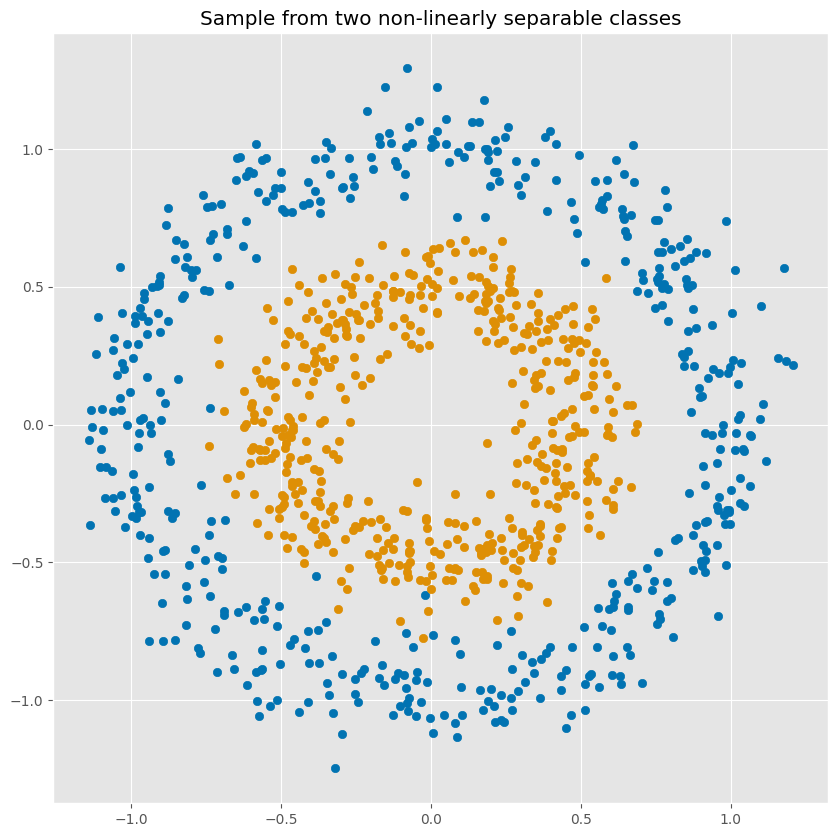

In [55]:
# Close all existing figures
plt.close('all')

# Define the standard deviation of noise for the circles
circle_std = 0.1

# Generate the non-linearly separable dataset with circles
X, y = make_circles(n_samples=1000, factor=0.5, noise=circle_std)

# Define a color palette for visualization
color_blind_list = sns.color_palette("colorblind")

# Plot the samples
plt.figure(figsize=(10,10))
for i, label in enumerate(y):
    # Use different colors for each class based on the color palette
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(label)]])
plt.title("Sample from two non-linearly separable classes")
plt.show()


**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.


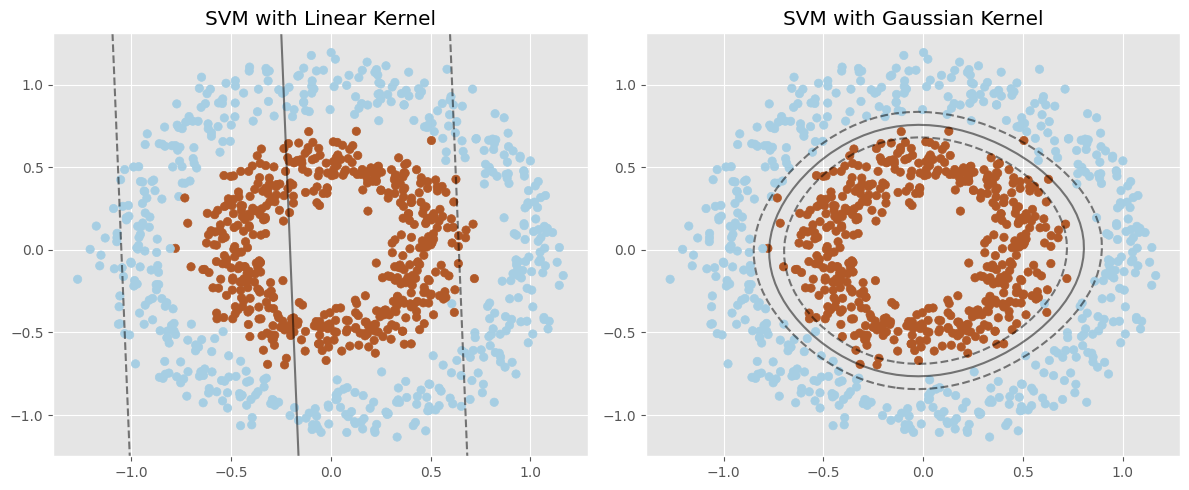

In [56]:
gammas = np.logspace(-4, 1, 10)
C_list = np.logspace(-1, 6, 10)
# Générer un ensemble de données non linéairement séparable avec make_moons
X, y = make_circles(n_samples=1000, factor=0.5, noise=circle_std)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM with linear kernel
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train, y_train)

# Train SVM with Gaussian kernel using GridSearchCV to find the best parameters
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
gaussian_svm = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3)
gaussian_svm.fit(X_train, y_train)

# Plot decision boundaries
plt.figure(figsize=(12, 5))

# Plot decision boundary for SVM with linear kernel
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = linear_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.title('SVM with Linear Kernel')

# Plot decision boundary for SVM with Gaussian kernel
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = gaussian_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.title('SVM with Gaussian Kernel')

plt.tight_layout()
plt.show()



## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.


I am going to change the distribution because I don't know why but the previous distribution does not work. Maybe it is caused by the fact that there is no gaussian distribution. 


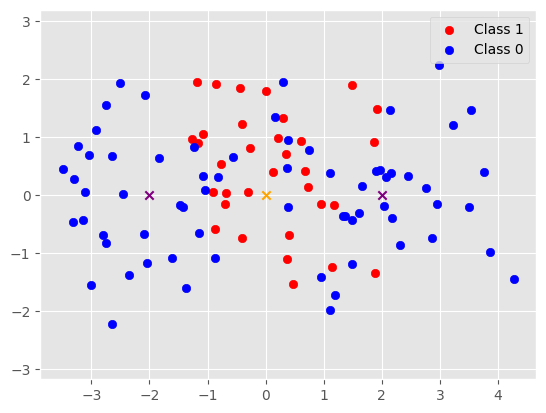

In [67]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0

# Create three centers for the three distributions
centers = np.array([[2, 0], [0, 0], [-2, 0]])

# Use make_blobs to generate the two dimensions points from the two centers
X_nlinear, y_nlinear = make_blobs(centers=centers, n_samples=100,random_state=0)

y_nlinear[y_nlinear==2] = 0

# Plot the points
pos = np.where(y_nlinear == 1)[0]
neg = np.where(y_nlinear == 0)[0]



plt.scatter(X_nlinear[pos,0], X_nlinear[pos,1], c='r', label='Class 1')
plt.scatter(X_nlinear[neg,0], X_nlinear[neg,1], c='b', label='Class 0')
plt.scatter(centers[0,0],centers[0,1], c='purple', marker='x')
plt.scatter(centers[1,0],centers[1,1], c='orange', marker='x')
plt.scatter(centers[2,0],centers[2,1], c='purple', marker='x')
plt.axis('equal')
plt.legend()
plt.show()

Using a gaussian kernel


Best parameters: {'C': 129.1549665014884, 'gamma': 0.05994842503189409, 'kernel': 'rbf'}
Best score: 0.8


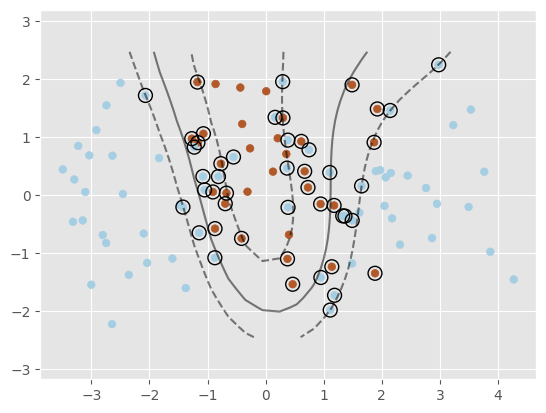

In [71]:
# Use the code of question 6 again

gammas = np.logspace(-4, 1, 10)
C_list = np.logspace(-1, 6, 10)

parameters = {'kernel': ['rbf'], 'C': C_list, 'gamma': gammas}
clf = GridSearchCV(SVC(), parameters, cv=5) 
clf.fit(X_nlinear, y_nlinear)
print('Using a gaussian kernel\n\n')

best_c=clf.best_params_['C']
best_gamma=clf.best_params_['gamma']

print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')


# display the decision boundary
C_star = clf.best_params_["C"]
gamma_star = clf.best_params_["gamma"]
clf = svm.SVC(kernel="rbf", C=C_star, gamma=gamma_star)
clf.fit(X_nlinear, y_nlinear)

# Plot the data
plt.scatter(X_nlinear[:, 0], X_nlinear[:, 1], c=y_nlinear, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()


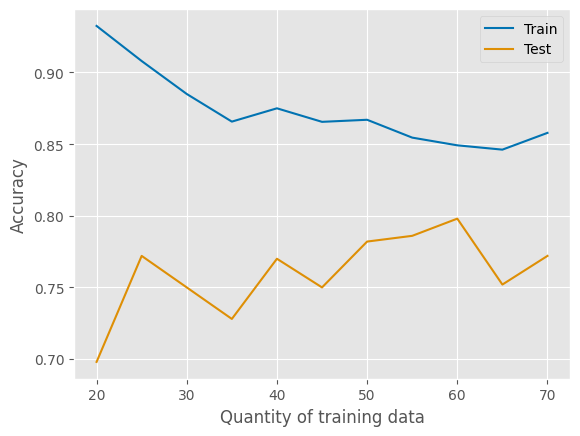

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_nlinear, y_nlinear, test_size=0.25, random_state=0)

# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times
n_m = 20

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf = svm.SVC(kernel="rbf", C=best_c, gamma=best_gamma)
        
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]

        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)

    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)
    

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [82]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4).

n_mc = 10000
expectation = 0

for i in range(n_mc):
    #rand between 0 and 2 , equiprobable
    rand = np.random.choice([0,1,2])
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], np.eye(2))
    elif rand == 1:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], np.eye(2))
    else:
        # Second case: y = 2
        x = np.random.multivariate_normal(centers[2], np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=np.eye(2))
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=np.eye(2))
    p3 = multivariate_normal.pdf(x, mean=centers[2], cov=np.eye(2))
    # Compute the risk from these and add it to the total
    if p2 > p1+p3 and rand != 1:
        expectation += 1 
    elif p2 < p1+p3 and rand == 1:
        expectation += 1
    

expectation /= n_mc


print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')


Estimated Bayes risk: 0.212
Estimated Bayes accuracy: 0.788


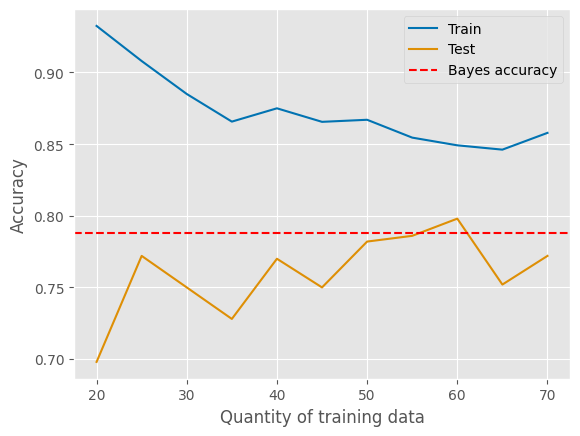

In [83]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.axhline(1 - expectation, color='r', linestyle='--', label='Bayes accuracy')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()


## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.



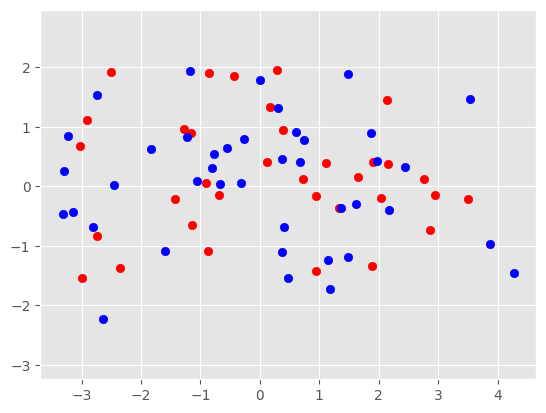

In [84]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

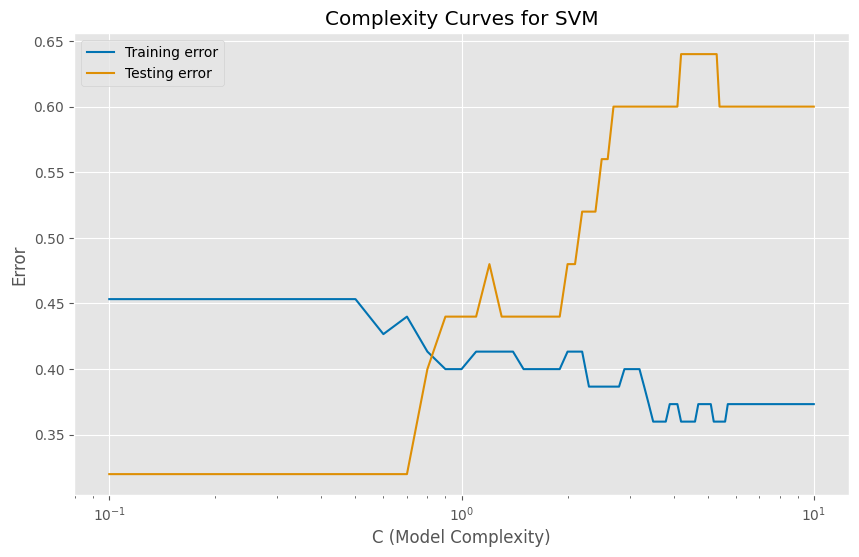

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Range of C values to explore
C_values = np.linspace(0.1, 10, 100)

train_errors = []
test_errors = []

for C in C_values:
    # Train the model with the current C value
    model = SVC(C=C, kernel='rbf')
    model.fit(X_train, y_train)
    
    # Predict on training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate errors
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    
    # Store errors for plotting
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plotting the complexity curve
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_errors, label='Training error')
plt.semilogx(C_values, test_errors, label='Testing error')
plt.xlabel('C (Model Complexity)')
plt.ylabel('Error')
plt.title('Complexity Curves for SVM')
plt.legend()
plt.show()



## Bonus : Application to face classification

Code for downloading and organizing the data:

In [52]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

**12)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

# Add the regularization parameter and test for a range of values
# Plot the performances
clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values


**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Apply the SVM with the chosen kernel after dimension reduction by PCA
